# Molecular Design with Parsl
This notebook demonstrates a simple molecular design application where we use machine learning to guide which computations we perform.
The objective of this demo is to find which molecules have the large ionization energies (IE, the amount of energy required to remove an electron)
where we employ machine learning to predict high IE molecules based on previous computations (a process [often called active learning](https://pubs.acs.org/doi/abs/10.1021/acs.chemmater.0c00768)). 

![workflow](./figures/workflow.svg)

In this notebook, you will see how to use Parsl to execute functions in parallel and how Parsl's integration with Python's native concurrency library (i.e., [`concurrent.futures`](https://docs.python.org/3/library/concurrent.futures.html#module-concurrent.futures)) let you write apps that dynamically respond to the completion of asynchronous tasks.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from chemfunctions import compute_vertical
from concurrent.futures import as_completed
from tqdm.notebook import tqdm
from parsl.executors import HighThroughputExecutor
from parsl.app.python import PythonApp
from parsl.app.app import python_app
from parsl.config import Config
from time import monotonic
import parsl
import pandas as pd
import numpy as np

## Define problem
The configuration parameters for the app: The search space of molecules and parameters controlling the optimization algorithm

In [2]:
search_space = pd.read_csv('data/QM9-search.tsv', delim_whitespace=True).sample(1024)  # Our search space of molecules

In [3]:
initial_count: int = 8  # Number of calculations to run at first

In [4]:
search_count: int = 16   # Number of molecules to evaluate in total

In [5]:
batch_size: int = 4  # Number of molecules to evaluate in each batch of simulations

## Set up Parsl
Our first step is to initialize Parsl.

The following will configure Parsl to run tasks on the local machine. This is where we would describe the details of (for example) a supercomputer, if we wanted to execute tasks there instead.

In [6]:
config = Config(
    executors=[HighThroughputExecutor(
        label='local',
        max_workers=2, # Allows a maximum of two workers 
        cpu_affinity='block'  # Assigns workers to specific cores
    )]
)

In [7]:
parsl.load(config)

## Make an initial dataset
We need data to train our ML models. We'll do that by selecting a set of molecules at random from  our search space, performing some simulations on those molecules, and training on the results.

In [`chemfunctions.py`](./chemfunctions.py), we have defined a function `compute_vertical` that computes the "vertical ionization energy" of a molecule (a measure of how much energy it takes to strip an electron off the molecule). `compute_vertical` takes a string representation of a molecule in [SMILES format](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) as input and returns the ionization energy as a float. Under the hood, it is running [xTB](https://xtb-docs.readthedocs.io/en/latest/contents.html) to perform a series of quantum chemistry computations.

We need to prepare this function to run with Parsl. All we need to do is wrap this function with Parsl's `python_app` function:

In [8]:
compute_vertical_app = python_app(compute_vertical)
compute_vertical_app

This new object is a Parsl `PythonApp`. It can be invoked like the original function, but instead of immediately executing, the function wil be scheduled to run inside Parsl asynchronously. Instead of the result, the call will immediately return a `Future` which will be used to retrieve the result later on.

For example, invoking compute_verticle_app with the SMILES for water, `O`, returns a Future and schedules `compute_verticle` for execution in the background.

In [9]:
future = compute_vertical_app('O') #  Run water as a demonstration (O is the SMILES for water) # TODO: is it water or a single oxygen?
future

<AppFuture super=<AppFuture at 0x7fdee1189a90 state=pending>>

We can access the result of this computation by asking the future for the `result()`. If the computation isn't finished yet, then the call to `.result()` will block until the result is ready.

In [10]:
ie = future.result()
print(f"The ionization energy of {future.task_def['args'][0]} is {ie:.2f} Ha")

The ionization energy of O is 0.67 Ha


Ok, now lets run the simulation for several different molecules and gather their results.

First we submit them, all at once. Each invocation returns a `Future` immediately, so this code should finish within a few milliseconds.

Because we never call `.result()`, this code does not wait for any results to be ready. Instead, Parsl is running the computations in the background. Parsl manages sending work to each worker process, collecting results, and feeding new work to workers as new tasks are submitted.

In [11]:
%%time
smiles = search_space.sample(initial_count)['smiles']
futures = [compute_vertical_app(s) for s in smiles]
print(f'Submitted {len(futures)} calculations to start with')

Submitted 8 calculations to start with
CPU times: user 4.02 ms, sys: 0 ns, total: 4.02 ms
Wall time: 4.45 ms


The futures Parsl produces are based on Python's [native "Future"](https://docs.python.org/3/library/concurrent.futures.html#future-objects) object,
so we can use Python's utility functions to work with them.

As an example, we can build a loop that submits new computations if previous ones fail. This happens not too infrequently with our simulation application.

This example uses another method, `Future.exception()`. This is similar to `Future.result()`. It will block until the relevant task is completed, but rather than the result, it returns any exception that was raised during exception (or `None` if not).

In [12]:
train_data = []
while len(futures) > 0: 
    # First, get the next completed computation from the list
    future = next(as_completed(futures))
    
    # Remove it from the list of still-running tasks
    futures.remove(future)
    
    # Get the input 
    smiles = future.task_def['args'][0]
    
    # Check if the run completed successfully
    if future.exception() is not None:
        # If it failed, pick a new SMILES string at random and submit it    
        print(f'Computation for {smiles} failed, submitting a replacement computation')
        smiles = search_space.sample(1).iloc[0]['smiles'] # pick one molecule
        new_future = compute_vertical_app(smiles) # launch a simulation in Parsl
        futures.append(new_future) # store the Future so we can keep track of it
    else:
        # If it succeeded, store the result
        print(f'Computation for {smiles} succeeded')
        train_data.append({
            'smiles': smiles,
            'ie': future.result(),
            'batch': 0,
            'time': monotonic()
        })

Computation for N=C1C=NOC(C=O)=C1 succeeded
Computation for N#CCC12CN1CC=C2 succeeded
Computation for CC1CC2(CC12C)C=O succeeded
Computation for CC1(CO1)C12CC1CO2 succeeded
Computation for OC1CC1(CC#N)C#N succeeded
Computation for CC1(C)OC(C#N)C1O succeeded
Computation for C1CC23OC(CC=C2)C13 failed, submitting a replacement computation
Computation for C1C=CC2C3C=CC1N23 succeeded
Computation for COC1=NNC(N)=C1 succeeded


We now have an initial set  of training data: a pandas `DataFrame` containing the randomly samples molecules alongside the simulated ionization energy (`ie`). In addition, the code above has stored some metadata (`batch` and `time`) which we will use later.

In [13]:
train_data = pd.DataFrame(train_data)
train_data

,smiles,ie,batch,time
0,N=C1C=NOC(C=O)=C1,0.507545,0,22117.538182
1,N#CCC12CN1CC=C2,0.490594,0,22121.836437
2,CC1CC2(CC12C)C=O,0.489504,0,22146.784515
3,CC1(CO1)C12CC1CO2,0.501569,0,22151.394323
4,OC1CC1(CC#N)C#N,0.534034,0,22165.545437
5,CC1(C)OC(C#N)C1O,0.520492,0,22165.890198
6,C1C=CC2C3C=CC1N23,0.465306,0,22186.515542
7,COC1=NNC(N)=C1,0.472285,0,22187.057632


## Train an initial machine learning model, use to screen candidates
Our next step for Parsl is to produce a machine learning model to estimate the outcome of new computations and use it to scan the search space.

To start, let's make a function that takes our existing data and uses it to train a model. We are going to use RDKit and scikit-learn to train a nearest-neighbor model that uses Morgan fingerprints to define similarity (see [notes from a UChicago AI course](https://github.com/WardLT/applied-ai-for-materials/blob/main/molecular-property-prediction/chemoinformatics/2_ml-with-fingerprints.ipynb) for more detail). In short, the function trains a model that first populates a list of whether certain substructures (Morgan fingerprints, specifically) and then trains a model which predicts the IE of a new molecule by averaging those with the most similar substructures.

We want it to run in Parsl, so we create the function using `python_app`. This time, `python_app` is used as a decorator directly on the function definition (earlier we defined a regular function, and then applied `python_app` afterwards).

In [14]:
@python_app
def train_model(train_data):
    """Train a machine learning model using Morgan Fingerprints.
    
    Args:
        train_data: Dataframe with a 'smiles' and 'ie' column
            that contains molecule structure and property, respectfully.
    Returns:
        A trained model
    """
    # Imports for python functions run remotely must be defined inside the function
    from chemfunctions import MorganFingerprintTransformer
    from sklearn.neighbors import KNeighborsRegressor
    from sklearn.pipeline import Pipeline
    
    
    model = Pipeline([
        ('fingerprint', MorganFingerprintTransformer()),
        ('knn', KNeighborsRegressor(n_neighbors=4, weights='distance', metric='jaccard', n_jobs=-1))  # n_jobs = -1 lets the model run all available processors
    ])
    
    return model.fit(train_data['smiles'], train_data['ie'])

Let's start it to run asynchronously:

In [15]:
train_future = train_model(train_data)

A great feature of Parsl is that it can create workflows on-the-fly from Python: chains of functions that can run in parallel when possible, waiting on dependencies as necessary.  **TODO: is this a relevant workflow definition for this tutorial?

To do so, we pass the future created by executing one function an input to another Parsl function.

As an example, let's create a function that uses the trained model to run inference on a large set of molecules and then another that takes many predictions and contatenates them into a single collection.

In [16]:
@python_app
def run_model(model, smiles):
    """Run a model on a list of smiles strings
    
    Args:
        model: Trained model that takes SMILES strings as inputs
        smiles: List of molecules to evaluate
    Returns:
        A dataframe with the molecules and their predicted outputs
    """
    import pandas as pd
    pred_y = model.predict(smiles)
    return pd.DataFrame({'smiles': smiles, 'ie': pred_y})

In [17]:
@python_app
def combine_inferences(inputs=[]):
    """Concatenate a series of inferences into a single DataFrame
    Args:
        inputs: a list of the component DataFrames
    Returns:
        A single DataFrame containing the same inferences
    """
    import pandas as pd
    return pd.concat(inputs, ignore_index=True)

Now we've made our definitions, we can chop up the search space into chunks, and invoke `run_model`  once for each chunk of the search space.

In [18]:
# Chunk the search space into smaller pieces, so that each can run in parallel
chunks = np.array_split(search_space['smiles'], 64)
inference_futures = [run_model(train_future, chunk) for chunk in chunks]

... and then combine the collections into a single DataFrame using `combine_inferences`.

Parsl will automatically arrange execution so that `train_future` must complete before any of the `run_model` tasks start; and all of the `run_model` tasks must be finished before `combine_inferences` starts.

In [19]:
# We pass the inputs explicitly as a named argument "inputs" for Parsl to recognize this as a "reduce" step
#  See: https://parsl.readthedocs.io/en/stable/userguide/workflow.html#mapreduce
predictions = combine_inferences(inputs=inference_futures).result()

We can print out the best five molecules, according to the trained model:

In [20]:
predictions.sort_values('ie', ascending=False).head(5)

,smiles,ie
930,OC1CC1(CC#N)C#N,0.534034
434,CC1(C)OC(C#N)C1O,0.520492
862,OC1COC(=O)C1O,0.516672
278,C#CCCC1OCCO1,0.516540
895,OC1C2OC2C1(O)C#C,0.516466


We now have the ability to train a model and use it to identify molecules that are likely to be good next choices for simulations. Time to build a model-in-the-loop workflow.

## Model-in-the-Loop Workflow
We are going to build an application that uses a machine learning model to pick a batch of simulations, runs the simulations in parallel, and then uses the data to retrain the model before repeating the loop.

This code uses `train_model`, `run_model` and `combine_inferences` as above, but repeatedly retrains the model using the predicted best molecules of each iteration until a fixed number of molecule simulations have been trained against:

In [21]:
with tqdm(total=search_count) as prog_bar: # setup a graphical progress bar
    prog_bar.update(len(train_data))
    batch = 1
    already_ran = set(train_data['smiles'])
    while len(train_data) < search_count:
        # Train and predict as show in the previous section.
        train_future = train_model(train_data)
        inference_futures = [run_model(train_future, chunk) for chunk in np.array_split(search_space['smiles'], 64)]
        predictions = combine_inferences(inputs=inference_futures).result()

        # Sort the predictions in descending order, and submit new molecules from them
        predictions.sort_values('ie', ascending=False, inplace=True)
        sim_futures = []
        for smiles in predictions['smiles']:
            if smiles not in already_ran:
                sim_futures.append(compute_vertical_app(smiles))
                already_ran.add(smiles)
                if len(sim_futures) >= batch_size:
                    break

        # Wait for every task in the current batch to complete, and store successful results
        new_results = []
        for future in as_completed(sim_futures):
            if future.exception() is None:
                prog_bar.update(1)
                new_results.append({
                    'smiles': future.task_def['args'][0],
                    'ie': future.result(),
                    'batch': batch, 
                    'time': monotonic()
                })
                
        # Update the training data and repeat
        batch += 1
        train_data = pd.concat((train_data, pd.DataFrame(new_results)), ignore_index=True)

  0%|          | 0/16 [00:00<?, ?it/s]

We can plot the training data against the time of simulation, showing that the model was finding better molecules later on in the run:

In [22]:
train_data['time'] = train_data['time'] - train_data['time'].min()

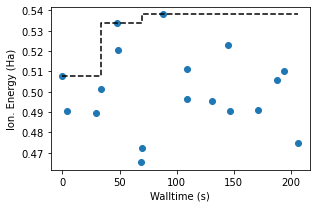

In [23]:
fig, ax = plt.subplots(figsize=(4.5, 3.))

ax.scatter(train_data['time'], train_data['ie'])
ax.step(train_data['time'], train_data['ie'].cummax(), 'k--')

ax.set_xlabel('Walltime (s)')
ax.set_ylabel('Ion. Energy (Ha)')

fig.tight_layout()

You can see how our search program finds better molecules over time!